<a href="https://colab.research.google.com/github/mazenomran/Surface-defect-detection/blob/main/Many_spatial_features_forTile_defects_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import the necessary libraries

In [3]:
import cv2
import pandas as pd
import numpy as np
import os
from skimage.filters import roberts, sobel, scharr, prewitt
from scipy import ndimage as nd
import time
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay
import pickle

#Preparing paths and empty lists to save data in

In [4]:
img_path = "/content/drive/MyDrive/augmented_train/"
img_path1 = "/content/drive/MyDrive/augmented_test/"

X_train =[]
y_train = []
X_test = []
y_test = []

#Preparing and labeling training data

In [5]:
for image in os.listdir(img_path):  # iterate through each file
    if image.split('.')[0][:3] == 'Def':
        y_train.append(1)
    else:
        y_train.append(0)

    input_img = cv2.imread(img_path + image)  # Read images
    img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
    X_train.append(img)

##Preparing and labeling testing data


In [6]:
for image1 in os.listdir(img_path1):  # iterate through each file
    if image1.split('.')[0][:3] == 'Def':
        y_test.append(1)
    else:
        y_test.append(0)

    input_img1 = cv2.imread(img_path1 + image1)  # Read images
    img1 = cv2.cvtColor(input_img1, cv2.COLOR_BGR2GRAY)
    X_test.append(img1)

In [7]:
X_train= np.array(X_train)
y_train= np.array(y_train)
X_test= np.array(X_test)
y_test= np.array(y_test)

# Normalize pixel values to between 0 and 1

In [8]:
X_train.shape

(974, 210, 210)

In [9]:
'''from google.colab.patches import cv2_imshow
cv2_imshow(X_train[15, :,:])'''

'from google.colab.patches import cv2_imshow\ncv2_imshow(X_train[15, :,:])'

# FEATURE EXTRACTOR function

In [10]:
# input shape is (n, x, y, c) - number of images, x, y, and channels
def feature_extractor(dataset):
    x_train = dataset
    image_dataset = pd.DataFrame()
    for image in range(x_train.shape[0]):  #iterate through each file 
        #print(image)
        
        df = pd.DataFrame()  #Temporary data frame to capture information for each loop.
        #Reset dataframe to blank after each loop.
        
        input_img = x_train[image, :,:]
        img = input_img
    ################################################################
    #START ADDING DATA TO THE DATAFRAME
    #Add feature extractors, e.g. edge detection, smoothing, etc. 
            
         # FEATURE 1 - Pixel values
         
        #Add pixel values to the data frame
        pixel_values = img.reshape(-1)/255.0
        df['Pixel_Value'] = pixel_values  #Pixel value itself as a feature
        #df['Image_Name'] = image   #Capture image name as we read multiple images

        # ROBERTS EDGE
        edge_roberts = roberts(img)
        edge_roberts1 = edge_roberts.reshape(-1)
        df['Roberts'] = edge_roberts1

        # SOBEL
        edge_sobel = sobel(img)
        edge_sobel1 = edge_sobel.reshape(-1)
        df['Sobel'] = edge_sobel1

        # SCHARR
        edge_scharr = scharr(img)
        edge_scharr1 = edge_scharr.reshape(-1)
        df['Scharr'] = edge_scharr1

        # PREWITT
        edge_prewitt = prewitt(img)
        edge_prewitt1 = edge_prewitt.reshape(-1)
        df['Prewitt'] = edge_prewitt1

        # CANNY EDGE
        img1 = np.uint8(img)
        edges = cv2.Canny(img1, 100, 200)  # Image, min and max values
        edges1 = edges.reshape(-1)/255.0
        df['Canny_Edge'] = edges1

        # GAUSSIAN with sigma=3
        gaussian_img = nd.gaussian_filter(img, sigma=3)
        gaussian_img1 = gaussian_img.reshape(-1)/255.0
        df['Gaussian3'] = gaussian_img1
        
        median_img = nd.median_filter(img, size=3)
        median_img1 = median_img.reshape(-1)/255.0
        df['Median3'] = median_img1
        #Append features from current image to the dataset
        image_dataset = pd.concat([image_dataset,df])
        
    return image_dataset

#Extract features from training images

In [11]:
image_features = feature_extractor(X_train)
image_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42953400 entries, 0 to 44099
Data columns (total 8 columns):
 #   Column       Dtype  
---  ------       -----  
 0   Pixel_Value  float64
 1   Roberts      float64
 2   Sobel        float64
 3   Scharr       float64
 4   Prewitt      float64
 5   Canny_Edge   float64
 6   Gaussian3    float64
 7   Median3      float64
dtypes: float64(8)
memory usage: 2.9 GB


#Reshape to a vector for Random Forest / SVM training

In [12]:
n_features = image_features.shape[1]
image_features = np.expand_dims(image_features, axis=0)
image_features.shape



(1, 42953400, 8)

In [13]:
X_Train = np.reshape(image_features, (X_train.shape[0], -1))  #Reshape to #images, features



In [14]:
X_Train.shape

(974, 352800)

#Predict on Test data

In [15]:

#Extract features from test data and reshape, just like training data
test_features = feature_extractor(X_test)
test_features = np.expand_dims(test_features, axis=0)
X_Test = np.reshape(test_features, (X_test.shape[0], -1))

In [16]:
X_Test.shape

(218, 352800)

#Random Forest model

Accuracy RF_model =  0.8211009174311926
Precision RF_model =  0.8
Recall RF_model =  0.8518518518518519
F1 Score RF_model =  0.8251121076233184 

Training RF_model time: 52.41603493690491
Testing RF_model time: 0.15543842315673828
One sample time :  0.0007130202897098086


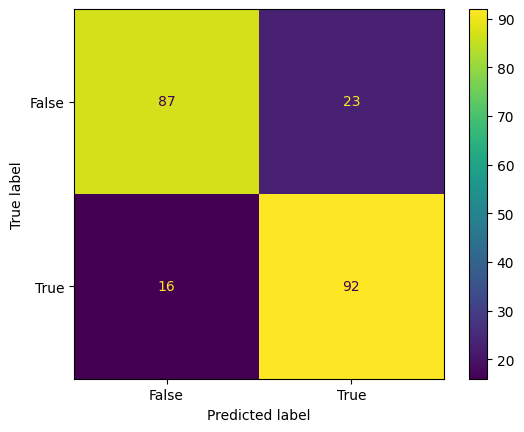

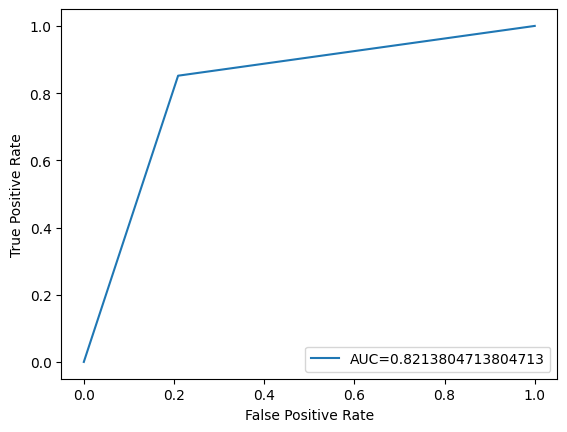

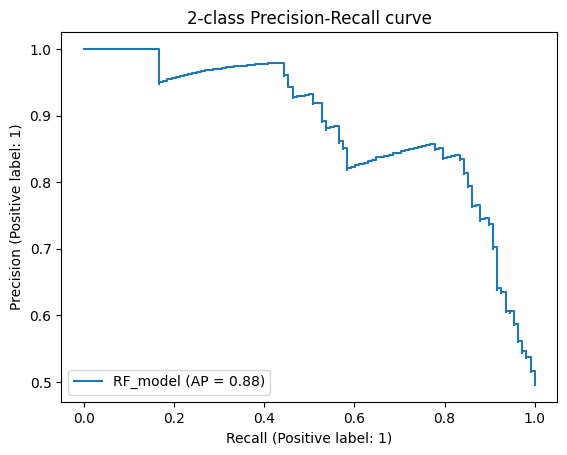

In [17]:
from sklearn.ensemble import RandomForestClassifier
## Instantiate model with n number of decision trees
RF_model = RandomForestClassifier(n_estimators = 250, min_samples_split = 6, min_samples_leaf= 12)
#Training the model and estimate training time 
t0 = time.time()
RF_model.fit(X_Train, y_train)
Training_time = time.time()-t0

#Predict on test
t1 = time.time()
test_prediction = RF_model.predict(X_Test)
Testing_time = time.time()-t1

##Check model metrics on test dataset.
print ("Accuracy RF_model = ", metrics.accuracy_score(y_test, test_prediction))
print ("Precision RF_model = ", metrics.precision_score(y_test, test_prediction))
print ("Recall RF_model = ", metrics.recall_score(y_test, test_prediction))
print ("F1 Score RF_model = ", metrics.f1_score(y_test, test_prediction),"\n")
print("Training RF_model time:",Training_time)
print("Testing RF_model time:", Testing_time)
print("One sample time : ",Testing_time/ X_test.shape[0])
#Confusion matrix plotting
confusion_matrix = metrics.confusion_matrix(y_test, test_prediction)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()
#AUC curve plotting
fpr, tpr, _ = metrics.roc_curve(y_test,  test_prediction)
auc = metrics.roc_auc_score(y_test, test_prediction)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()
#Precision - Recall curve plotting
display = PrecisionRecallDisplay.from_estimator(
  RF_model, X_Test, y_test, name="RF_model")
_ = display.ax_.set_title("2-class Precision-Recall curve")

#SVM model

Accuracy SVM_model =  0.8394495412844036
Precision SVM_model =  0.811965811965812
Recall SVM_model =  0.8796296296296297
F1 Score SVM_model =  0.8444444444444444 

Training SVM_model time: 124.35133337974548
Testing SVM_model time: 24.4421489238739
One sample time :  0.11211994919208211


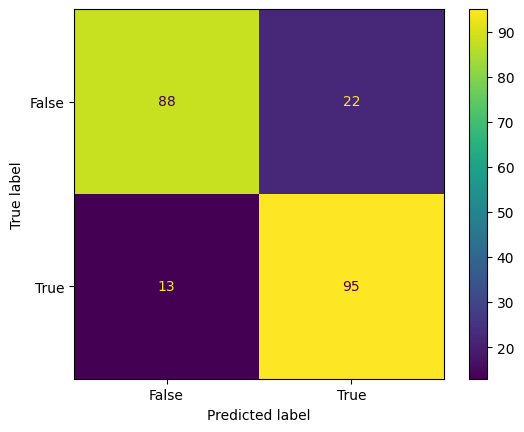

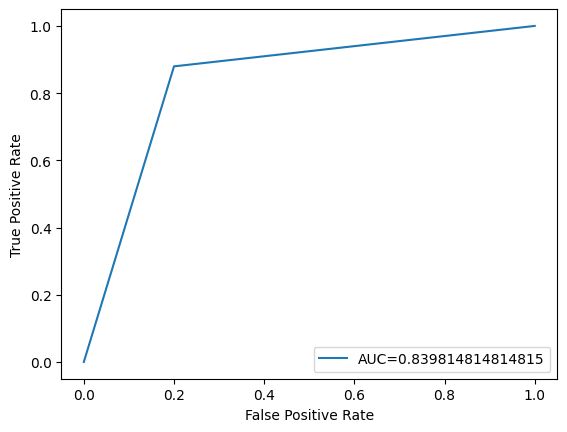

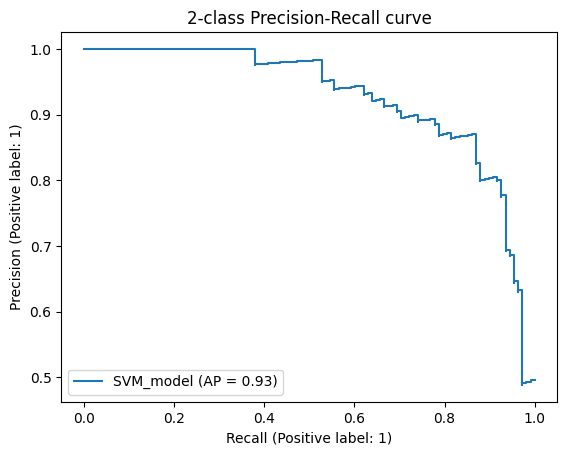

In [18]:
from sklearn import svm
SVM_model = svm.SVC(kernel='poly')
#Training the model and estimate training time 
t0 = time.time()
SVM_model.fit(X_Train, y_train)
Training_time = time.time()-t0

#Predict on test
t1 = time.time()
test_prediction = SVM_model.predict(X_Test)
Testing_time = time.time()-t1

##Check model metrics on test dataset.
print ("Accuracy SVM_model = ", metrics.accuracy_score(y_test, test_prediction))
print ("Precision SVM_model = ", metrics.precision_score(y_test, test_prediction))
print ("Recall SVM_model = ", metrics.recall_score(y_test, test_prediction))
print ("F1 Score SVM_model = ", metrics.f1_score(y_test, test_prediction),"\n")
print("Training SVM_model time:",Training_time)
print("Testing SVM_model time:", Testing_time)
print("One sample time : ",Testing_time/ X_test.shape[0])
#Confusion matrix plotting
confusion_matrix = metrics.confusion_matrix(y_test, test_prediction)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()
#AUC curve plotting
fpr, tpr, _ = metrics.roc_curve(y_test,  test_prediction)
auc = metrics.roc_auc_score(y_test, test_prediction)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()
#Precision - Recall curve plotting
display = PrecisionRecallDisplay.from_estimator(
  SVM_model, X_Test, y_test, name="SVM_model")
_ = display.ax_.set_title("2-class Precision-Recall curve")

#Logistic Regression model